In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 10000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

由于不需要预测数字，所以没有增加一维的数字位，可在后面修改

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [5]:
# (60000, 784) 的x_train切片，切成60000份，每个train_data都是 784的大小
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# repeat() 相当于一个dataset训练两遍，batch是一次取出256个image的数据，prefetch(1)是每次预存一个batch，shuffle指一个pool有多大
train_data = train_data.repeat().shuffle(1000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [6]:
class VAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder1 = tf.keras.layers.Dense(units=num_hidden_1, activation=tf.nn.sigmoid)
        self.encoder2 = tf.keras.layers.Dense(units=num_hidden_2, activation=tf.nn.sigmoid)
        self.decoder1 = tf.keras.layers.Dense(units=num_hidden_1, activation=tf.nn.sigmoid)
        self.decoder2 = tf.keras.layers.Dense(units=num_features, activation=tf.nn.sigmoid)
        
    @tf.function
    def encode(self, inputs):         
        x = self.encoder1(inputs)
        x = self.encoder2(x)
        return x
    
    @tf.function
    def decode(self, inputs):         
        x = self.decoder1(inputs)
        x = self.decoder2(x)
        return x

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae = VAE()

# take 是取某个数量的batch的数据出来。enumerate只是为了增加一个index
for step, (x, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        latent = vae.encode(x)
        y_pred = vae.decode(latent)
        loss = tf.reduce_mean(tf.pow(x - y_pred, 2))
        
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
        
    # Compute gradients.
    gradients = g.gradient(loss, vae.variables)

    optimizer.apply_gradients(grads_and_vars=zip(gradients, vae.variables))

step: 0, loss: 0.236000
step: 1000, loss: 0.015350
step: 2000, loss: 0.010706
step: 3000, loss: 0.008649
step: 4000, loss: 0.006814
step: 5000, loss: 0.005928
step: 6000, loss: 0.005734
step: 7000, loss: 0.005414
step: 8000, loss: 0.005019
step: 9000, loss: 0.004747
step: 10000, loss: 0.004617


Original Images


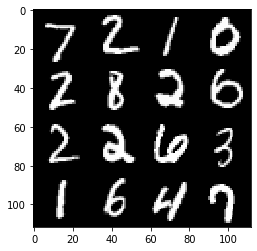

In [8]:
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = vae.decode(vae.encode(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

Reconstructed Images


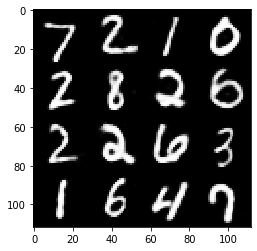

In [9]:
print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

这个只是个AE而不是VAE，要约束平均数和方差才行，所以这个生成效果极差，回来在搞，todo 

按道理来说，只需要修改loss即可

In [10]:
num_new_img = 16
shape = [num_new_img, num_hidden_2]
latent = tf.keras.backend.random_normal(shape=shape, mean=0.0, stddev=1.0, dtype=None, seed=None)

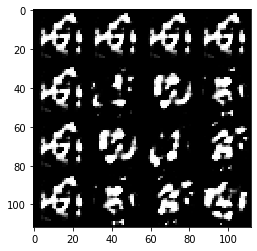

In [11]:
n = 4
canvas_recon = np.empty((28 * n, 28 * n))
new_images = vae.decode(latent)
for i in range(n):
    for j in range(n):
        img = new_images[i*j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()